<a href="https://colab.research.google.com/github/kundajelab/chipseqvnewtech/blob/master/H1_POU5F1_NANOG/ChIPseq_NANOG_POU5F1_CUTNRUN_POU5F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%bash

#Download relevant data
#For information on data prep, see https://github.com/kundajelab/chipseqvnewtech/blob/master/H1_POU5F1_NANOG/prep_data.sh
webdir=http://ec2-13-56-107-121.us-west-1.compute.amazonaws.com/chipseq_vs_newtech/H1_POU5F1_NANOG

download_if_not_there () {
  local file=$1
  [[ -f $file ]] || wget $webdir/$file -O $file
}

download_if_not_there CUTNRUN.POU5F1.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.minFL150bp.5p.counts.bigWig
download_if_not_there CUTNRUN.POU5F1.narrowpeak.gz
download_if_not_there CUTNRUN.IgG.standard.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.standard.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.standard.minFL150bp.5p.counts.bigWig

download_if_not_there CUTNRUN.NANOG.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.minFL150bp.5p.counts.bigWig
download_if_not_there CUTNRUN.NANOG.narrowpeak.gz
download_if_not_there CUTNRUN.IgG.merged.auto.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.merged.auto.maxFL120bp.5p.counts.bigWig
download_if_not_there CUTNRUN.IgG.merged.auto.minFL150bp.5p.counts.bigWig

download_if_not_there ChIPseq.POU5F1.merged.5p.counts.plus.bigWig
download_if_not_there ChIPseq.POU5F1.merged.5p.counts.minus.bigWig
download_if_not_there ChIPseq.POU5F1.narrowpeak.gz
download_if_not_there ChIPseq.NANOG.merged.5p.counts.plus.bigWig
download_if_not_there ChIPseq.NANOG.merged.5p.counts.minus.bigWig
download_if_not_there ChIPseq.NANOG.narrowpeak.gz
download_if_not_there ChIPseq.control.bigWig

In [0]:
#install software
!pip install pyfaidx
!pip install pyBigWig
!apt-get install bedtools
#installing samtools
%cd /content
![[ -f samtools-1.9.tar.bz2 ]] || wget https://github.com/samtools/samtools/releases/download/1.9/samtools-1.9.tar.bz2
!tar -xjf samtools-1.9.tar.bz2
%cd samtools-1.9
!./configure
!make
!make install
%cd ..

#download the hg38 genome, build the index
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
![[ -f hg38.genome.fa.fai ]] || samtools faidx hg38.genome.fa
#Download the ENCODE ebv-containing chromsizes file
![[ -f hg38.chrom.sizes ]] || wget https://raw.githubusercontent.com/ENCODE-DCC/encValData/master/GRCh38/GRCh38_EBV.chrom.sizes -O hg38.chrom.sizes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 2s (271 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...
/content
--2019-07-08 01:48:07--  https://github.com/samtools/samtools/releases/download/1.9/samtools-1.9.tar.bz2
Resolving github.com (github.com)... 1

In [0]:
#preparing the BED regions
#first concatenate peaks in the files you care about
!zcat ChIPseq.NANOG.narrowpeak.gz ChIPseq.POU5F1.narrowpeak.gz CUTNRUN.POU5F1.narrowpeak.gz | gzip -c > concatenated_peaks.narrowpeak.gz
#get 2kb around summits
!zcat concatenated_peaks.narrowpeak.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g hg38.chrom.sizes -b 1000 | perl -lane 'if ($F[2]-$F[1]==2000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > 2k_around_summits.bed.gz
#split into train, valid, test sets by chromosome
!zcat 2k_around_summits.bed.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_2k_around_summits.bed.gz
!zcat 2k_around_summits.bed.gz | egrep -w 'chr22' | gzip -c > valid_2k_around_summits.bed.gz
!zcat 2k_around_summits.bed.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_2k_around_summits.bed.gz

In [0]:
!rm -rf seqdataloader
!pip uninstall seqdataloader
![[ -e seqdataloader ]] || git clone https://github.com/kundajelab/seqdataloader.git
!pip install seqdataloader/

Uninstalling seqdataloader-0.126:
  Would remove:
    /usr/local/bin/genomewide_labels
    /usr/local/lib/python3.6/dist-packages/seqdataloader-0.126.dist-info/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/*
Proceed (y/n)? y
  Successfully uninstalled seqdataloader-0.126
Cloning into 'seqdataloader'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 611 (delta 64), reused 67 (delta 32), pack-reused 508
Receiving objects: 100% (611/611), 3.80 MiB | 3.55 MiB/s, done.
Resolving deltas: 100% (390/390), done.
Processing ./seqdataloader
  Stored in directory: /tmp/pip-ephem-wheel-cache-3wosnoxx/wheels/c2/db/13/112d41662f69fb8c7986c218293570cc1550fc21eed966e31b
Successfully built seqdataloader


In [0]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers

#Written by Žiga Avsec
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#If we want to avoid zero-padding, then the size of the output predictions
# will depend on the size of the input sequence supplied. We define the
# API for an AbstractProfileModel class which returns the length of the
# output profile in addition to returning the model, given information
# on the size of the input sequence and the model parameters.
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()
  
#The architecture by Žiga Avsec involves residual connections, which means
# that the layers being added together in an elementwise fashion need
# to have the same dimensions. To achieve this without zero-padding, we
# have to trim away the flanks of earlier convolutional layers. That
# is what this function is meant to do. (Note that the original BP-net
# architecture zero-pads; this is a modification to avoid the zero
# padding and use information on actual sequence instead)
def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer
        
#This model architecture is based on BP-Net by Žiga Avsec
# https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view
#It has been modified for this specific use-case.
class BPnetArch(AbstractProfileModel):   

    def __init__(self, input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr):
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr
    
    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len
    
    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        out_pred_len = self.get_output_profile_len()
        
        #'inp' is the one-hot encoded DNA sequence input
        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = kl.Conv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        #Need to keep track of the layer size for trimming purposes when
        # we get to the residual connections.
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        
        #Define input layers for the control tracks - both counts and profile
        #Dimension is '1' for the ChIP-seq control counts because the positive
        # and negative strands are added together
        chipseq_control_counts_input = kl.Input(
            shape=(1,), name="ChIPseq.control.logcount")
        cutnrun_control_standard_counts_input = kl.Input(
            shape=(1,), name="CUTNRUN.control.standard.logcount")
        #cutnrun_control_auto_counts_input = kl.Input(
        #    shape=(1,), name="CUTNRUN.control.auto.logcount")
        
        #Second dimension for the profile tasks are twice those for the
        # respective counts tasks because in addition to the original profile,
        # we supply the profile smoothed by 50bp.
        chipseq_control_profile_input = kl.Input(
            shape=(out_pred_len, 2), name="ChIPseq.control.profile")
        cutnrun_control_standard_profile_input = kl.Input(
            shape=(out_pred_len, 2), name="CUTNRUN.control.standard.profile")
        #cutnrun_control_auto_profile_input = kl.Input(
        #    shape=(out_pred_len, 2), name="CUTNRUN.control.auto.profile")
        
        #Gather together all the tensors representing the model inputs
        model_inputs = [
            inp,
            chipseq_control_counts_input,
            cutnrun_control_standard_counts_input,
            #cutnrun_control_auto_counts_input,
            chipseq_control_profile_input,
            cutnrun_control_standard_profile_input,
            #cutnrun_control_auto_profile_input
        ]
        
        #Prepare the stack of dilated convolutions with residual connections
        prev_layers = [first_conv]
        for i in range(1, self.n_dil_layers + 1):
          dilation_rate = 2**i
          if i == 1:
              prev_sum = first_conv
          else:
              prev_sum = kl.merge.Add()(prev_layers)
          conv_output = kl.Conv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_sum)          
          width_to_trim = dilation_rate*(self.dil_kernel_size-1)
          curr_layer_size = (curr_layer_size - width_to_trim)
          prev_layers = [trim_flanks_of_conv_layer(
              conv_layer=x, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=self.filters)
              for x in prev_layers]
          prev_layers.append(conv_output)

        combined_conv = kl.merge.Add()(prev_layers)

        #gap = GlobalAveragePooling. This layer is used as input for the
        # counts prediction tasks.
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        
        lossarr = []
        lossweightsarr = []
        model_outputs = []
        
        #Define the output layers for the counts prediction tasks
        for countouttaskname, numunits, countcontrolinp in [
          ("ChIPseq.POU5F1.logcount", 2, chipseq_control_counts_input),
          ("ChIPseq.NANOG.logcount", 2, chipseq_control_counts_input),
          ("CUTNRUN.POU5F1.logcount", 1, cutnrun_control_standard_counts_input),
          #("CUTNRUN.NANOG.logcount", 1, cutnrun_control_auto_counts_input)
        ]:
          count_out = kl.Dense(units=numunits,
                                 name=countouttaskname)(
              kl.concatenate([gap_combined_conv, countcontrolinp], axis=-1))
          model_outputs.append(count_out)
          lossarr.append('mse')
          lossweightsarr.append(self.c_task_weight)

        #Define the output layers for the profile prediction tasks
        for profileouttaskname, numunits, profilecontrolinp in [
          ("ChIPseq.POU5F1.profile", 2, chipseq_control_profile_input),
          ("ChIPseq.NANOG.profile", 2, chipseq_control_profile_input),
          ("CUTNRUN.POU5F1.profile", 1, cutnrun_control_standard_profile_input),
          #("CUTNRUN.NANOG.profile", 1, cutnrun_control_auto_profile_input)
        ]:     
          profile_out_precontrol = kl.Conv1D(
                                 filters=numunits,
                                 kernel_size=self.outconv_kernel_size,
                                 padding='valid')(combined_conv)
          profile_out = kl.Conv1D(
              filters=numunits, kernel_size=1, name=profileouttaskname)(
                      kl.concatenate([profile_out_precontrol,
                                      profilecontrolinp], axis=-1))
          model_outputs.append(profile_out)
          lossarr.append(MultichannelMultinomialNLL(numunits)) 
          #We downweight the loss by the number of channels because, if you
          # read the code for MultichannelMultinomialNLL, you'll see that
          # the loss for different channels is added together;
          # but I (Avanti Shrikumar) didn't want to implicitly upweight
          # the prediction tasks that happen
          # to have more channels, hence this downweighting.
          lossweightsarr.append(1.0/numunits)

        #Compile the model and return it
        model = keras.models.Model(inputs=model_inputs, outputs=model_outputs)
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=lossarr,
                      loss_weights=lossweightsarr)
        return model

seq_len = 1346
modelwrapper = BPnetArch(
    input_seq_len=seq_len, c_task_weight=500,
    filters=64, n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)
out_pred_len = modelwrapper.get_output_profile_len()
print(out_pred_len, seq_len-out_pred_len)

#the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
#Note that we log-transform our counts using np.log(counts+1)
#Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="hg38.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="ChIPseq.control.logcount",
        profile_mode_name="ChIPseq.control.profile",
        bigwig_paths=["ChIPseq.control.bigWig"],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
            coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),        
        center_size_to_use=out_pred_len),
     #coordstovals.bigwig.MultiTrackCountsAndProfile(
     #   counts_mode_name="CUTNRUN.control.auto.logcount",
     #   profile_mode_name="CUTNRUN.control.auto.profile",
     #   bigwig_paths=["CUTNRUN.IgG.merged.auto.5p.counts.bigWig",
     #                 "CUTNRUN.IgG.merged.auto.maxFL120bp.5p.counts.bigWig",
     #                 "CUTNRUN.IgG.merged.auto.minFL150bp.5p.counts.bigWig"],
     #   counts_and_profiles_transformer=
     #     coordstovals.bigwig.LogCountsPlusOne().chain(
     #       coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),
     #   center_size_to_use=out_pred_len),
     coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="CUTNRUN.control.standard.logcount",
        profile_mode_name="CUTNRUN.control.standard.profile",
        bigwig_paths=["CUTNRUN.IgG.standard.5p.counts.bigWig",
                      #"CUTNRUN.IgG.standard.maxFL120bp.5p.counts.bigWig",
                      #"CUTNRUN.IgG.standard.minFL150bp.5p.counts.bigWig"
                     ],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
            coordstovals.bigwig.SmoothProfiles(smoothing_windows=[1,50])),       
        center_size_to_use=out_pred_len)
    ])
targets_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="ChIPseq.POU5F1.logcount",
        profile_mode_name="ChIPseq.POU5F1.profile",
        pos_strand_bigwig_path="ChIPseq.POU5F1.merged.5p.counts.plus.bigWig",
        neg_strand_bigwig_path="ChIPseq.POU5F1.merged.5p.counts.minus.bigWig",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="ChIPseq.NANOG.logcount",
        profile_mode_name="ChIPseq.NANOG.profile",
        pos_strand_bigwig_path="ChIPseq.NANOG.merged.5p.counts.plus.bigWig",
        neg_strand_bigwig_path="ChIPseq.NANOG.merged.5p.counts.minus.bigWig",
        center_size_to_use=out_pred_len),
      coordstovals.bigwig.MultiTrackCountsAndProfile(
        counts_mode_name="CUTNRUN.POU5F1.logcount",
        profile_mode_name="CUTNRUN.POU5F1.profile",
        bigwig_paths=["CUTNRUN.POU5F1.5p.counts.bigWig",
                      #"CUTNRUN.POU5F1.maxFL120bp.5p.counts.bigWig",
                      #"CUTNRUN.POU5F1.minFL150bp.5p.counts.bigWig"
                     ],
        counts_and_profiles_transformer=
          coordstovals.bigwig.LogCountsPlusOne().chain(
              coordstovals.bigwig.SmoothProfiles(smoothing_windows=[10])),
        center_size_to_use=out_pred_len),
      #coordstovals.bigwig.MultiTrackCountsAndProfile(
      #  counts_mode_name="CUTNRUN.NANOG.logcount",
      #  profile_mode_name="CUTNRUN.NANOG.profile",
      #  bigwig_paths=["CUTNRUN.NANOG.5p.counts.bigWig",
      #                "CUTNRUN.NANOG.maxFL120bp.5p.counts.bigWig",
      #                "CUTNRUN.NANOG.minFL150bp.5p.counts.bigWig"],
      #  counts_and_profiles_transformer=coordstovals.bigwig.LogCountsPlusOne().chain(
      #        coordstovals.bigwig.SmoothProfiles(smoothing_windows=[10])),
      #  center_size_to_use=out_pred_len)
    ])

def qc_func(inputs, targets):
    return (targets['CUTNRUN.POU5F1.logcount'][:,0] <= 8)

keras_train_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="train_2k_around_summits.bed.gz",
      coord_batch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="hg38.chrom.sizes")),
      batch_size=64,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals,
  qc_func=qc_func
)
keras_valid_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="valid_2k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals
)

#As a sanity check, print out the dimensions of everything in individual batches
sampinputs,samptargets = keras_train_batch_generator[0]
for key in sampinputs:
  print(key, sampinputs[key].shape)
for key in samptargets:
  print(key, samptargets[key].shape)
    
model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)
loss_history = model.fit_generator(keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback])
model.set_weights(early_stopping_callback.best_weights)

1000 346
sequence (128, 1346, 4)
ChIPseq.control.logcount (128, 1)
ChIPseq.control.profile (128, 1000, 2)
CUTNRUN.control.standard.logcount (128, 1)
CUTNRUN.control.standard.profile (128, 1000, 2)
ChIPseq.POU5F1.logcount (128, 2)
ChIPseq.POU5F1.profile (128, 1000, 2)
ChIPseq.NANOG.logcount (128, 2)
ChIPseq.NANOG.profile (128, 1000, 2)
CUTNRUN.POU5F1.logcount (128, 1)
CUTNRUN.POU5F1.profile (128, 1000, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 1326, 64)     5440        sequence[0][0]                   
_________________________________________________________________________________________________

In [0]:
#in case the previous cell was interrupted
model.set_weights(early_stopping_callback.best_weights) 
model_name = "Oct4NanogChIP_Oct4CUTNRUN_Oct4cnrpeaksincluded.h5" 
model.save(model_name)

#check that the model can be reloaded
#to reload, you need to set up a CustomObjectScope
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
  loaded_model = load_model(model_name)

In [0]:
from google.colab import files
files.download(model_name) #download file from colab to computer

In [0]:
keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="test_2k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

In [0]:
import numpy as np

def extend_generator(generator):
  samp_inputs, samp_targets = generator[0]
  concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
  concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])
  for batch_idx in range(len(generator)):
    batch_inputs, batch_targets = generator[batch_idx]
    for key in batch_inputs:
      concat_inputs[key].extend(batch_inputs[key])
    for key in batch_targets:
      concat_targets[key].extend(batch_targets[key])
  for key in concat_inputs:
    concat_inputs[key] = np.array(concat_inputs[key])
  for key in concat_targets:
    concat_targets[key] = np.array(concat_targets[key])
  return (concat_inputs, concat_targets)

test_inputs, test_targets = extend_generator(keras_test_batch_generator)      

In [0]:
test_preds = OrderedDict(zip(loaded_model.output_names, loaded_model.predict(test_inputs)))

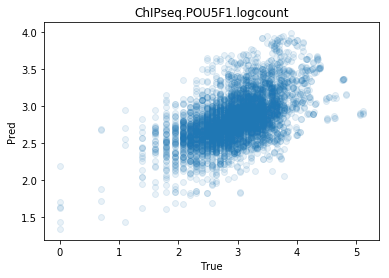

SpearmanrResult(correlation=0.5488100302285029, pvalue=0.0)


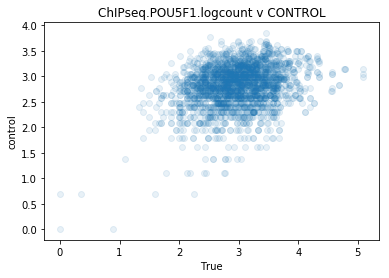

SpearmanrResult(correlation=0.22574404754578856, pvalue=4.1210635700111105e-28)


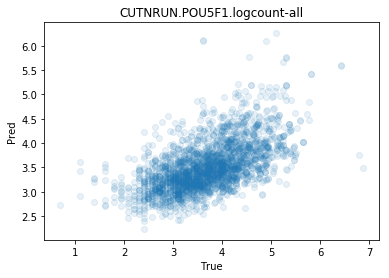

SpearmanrResult(correlation=0.5945533452203494, pvalue=3.6500643400277943e-221)


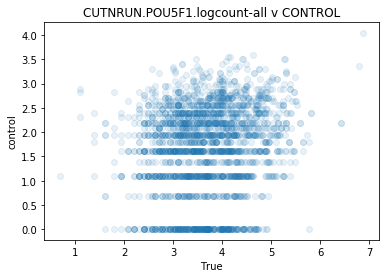

SpearmanrResult(correlation=0.14305510171382513, pvalue=4.781999652141459e-12)


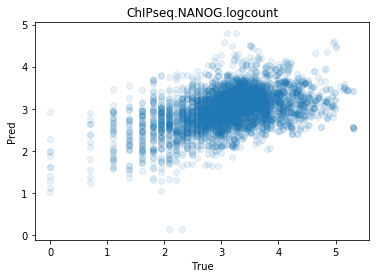

SpearmanrResult(correlation=0.4339246684619461, pvalue=9.240545312334853e-212)


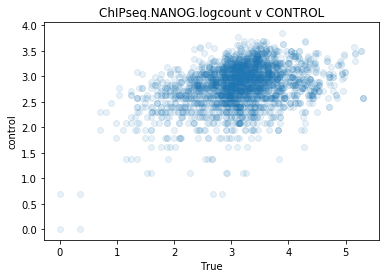

SpearmanrResult(correlation=0.316747792009793, pvalue=4.58417138279299e-55)


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr

def plot_scatter(xvals, yvals, xlabel, ylabel, title):
  plt.scatter(xvals, yvals, alpha=0.1)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  print(spearmanr(xvals,yvals))
  
plot_scatter(xvals=test_targets['ChIPseq.POU5F1.logcount'].ravel(),
             yvals=test_preds['ChIPseq.POU5F1.logcount'].ravel(),
             xlabel="True", ylabel="Pred", title="ChIPseq.POU5F1.logcount")
plot_scatter(xvals=np.mean(test_targets['ChIPseq.POU5F1.logcount'],axis=-1),
             yvals=test_inputs['ChIPseq.control.logcount'],
             xlabel="True", ylabel="control", title="ChIPseq.POU5F1.logcount v CONTROL")

plot_scatter(xvals=test_targets['CUTNRUN.POU5F1.logcount'][:,0],
             yvals=test_preds['CUTNRUN.POU5F1.logcount'][:,0],
             xlabel="True", ylabel="Pred", title="CUTNRUN.POU5F1.logcount-all")
plot_scatter(xvals=test_targets['CUTNRUN.POU5F1.logcount'][:,0],
             yvals=test_inputs['CUTNRUN.control.standard.logcount'][:,0],
             xlabel="True", ylabel="control", title="CUTNRUN.POU5F1.logcount-all v CONTROL")

plot_scatter(xvals=test_targets['ChIPseq.NANOG.logcount'].ravel(),
             yvals=test_preds['ChIPseq.NANOG.logcount'].ravel(),
             xlabel="True", ylabel="Pred", title="ChIPseq.NANOG.logcount")
plot_scatter(xvals=np.mean(test_targets['ChIPseq.NANOG.logcount'],axis=-1),
             yvals=test_inputs['ChIPseq.control.logcount'],
             xlabel="True", ylabel="control", title="ChIPseq.NANOG.logcount v CONTROL")  


#plot_scatter(xvals=test_targets['CUTNRUN.NANOG.logcount'][:,0],
#             yvals=test_preds['CUTNRUN.NANOG.logcount'][:,0],
#             xlabel="True", ylabel="Pred", title="CUTNRUN.NANOG.logcount-all")
#plot_scatter(xvals=test_targets['CUTNRUN.NANOG.logcount'][:,0],
#             yvals=test_inputs['CUTNRUN.control.auto.logcount'][:,0],
#             xlabel="True", ylabel="control", title="CUTNRUN.NANOG.logcount-all v CONTROL")

1601
NANOG ChIPseq preds


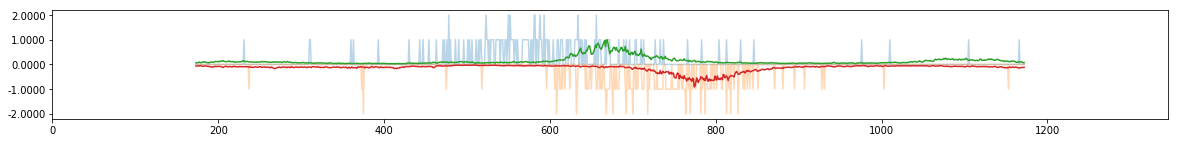

POU5F1 ChIPseq preds


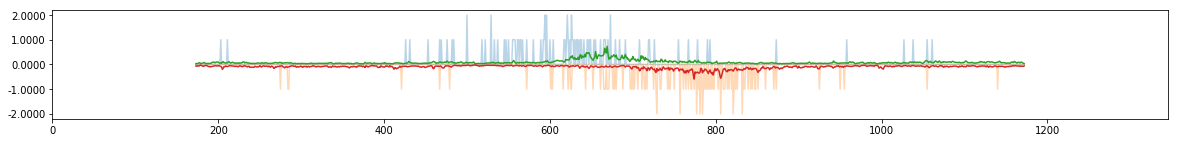

POU5F1 CUTNRUN preds


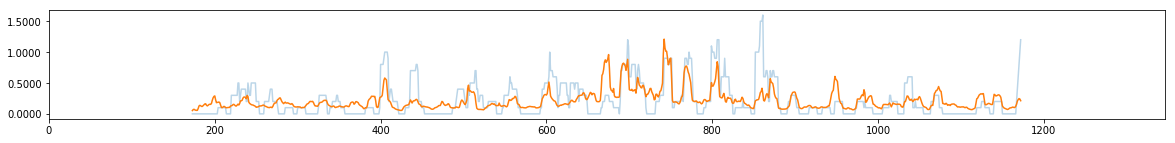

1602
NANOG ChIPseq preds


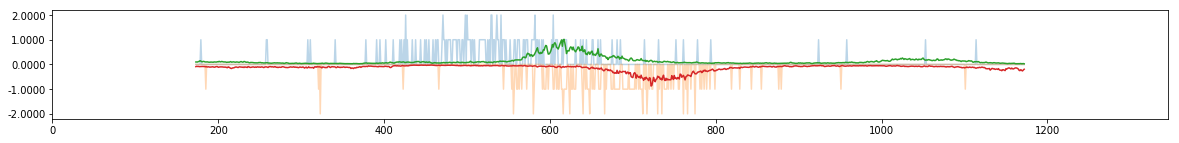

POU5F1 ChIPseq preds


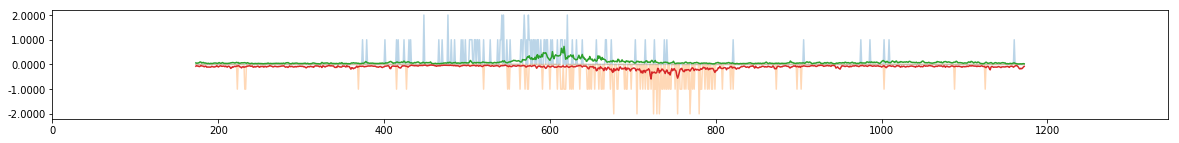

POU5F1 CUTNRUN preds


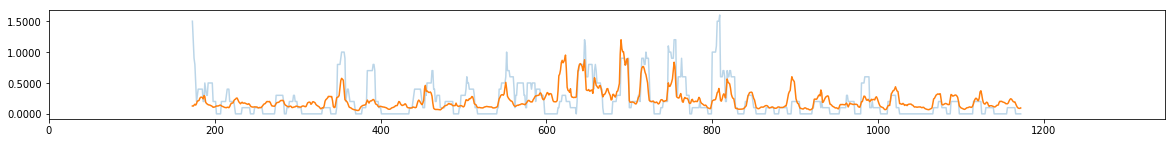

1600
NANOG ChIPseq preds


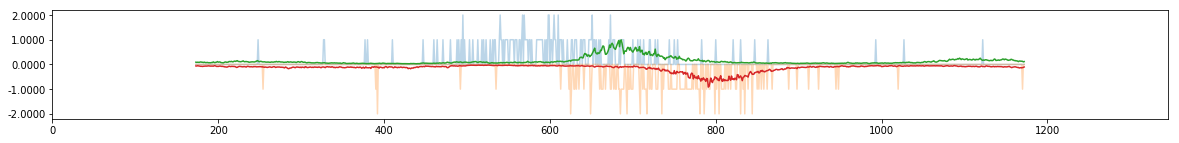

POU5F1 ChIPseq preds


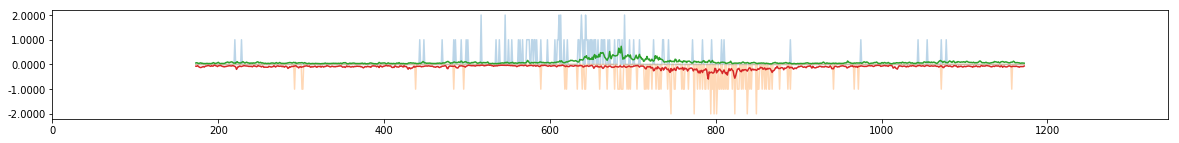

POU5F1 CUTNRUN preds


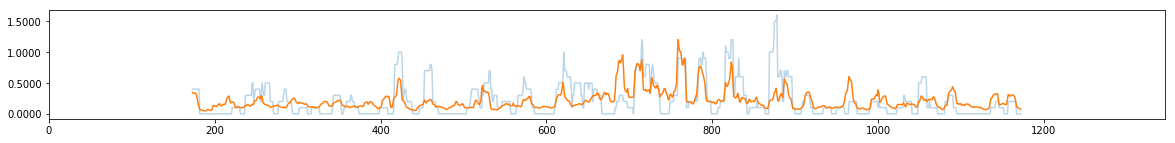

1923
NANOG ChIPseq preds


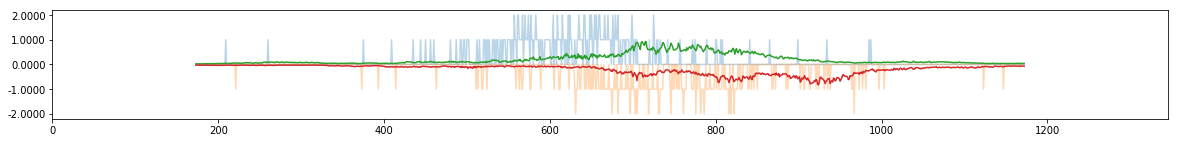

POU5F1 ChIPseq preds


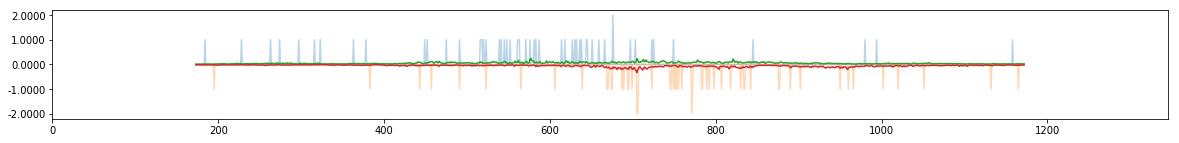

POU5F1 CUTNRUN preds


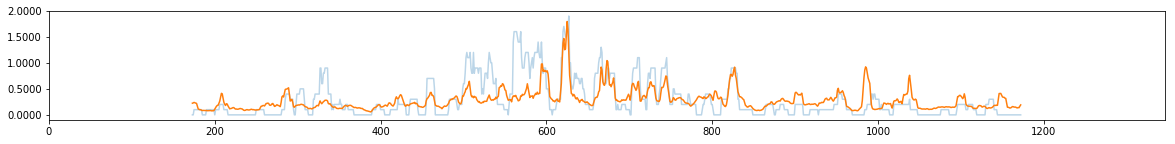

1924
NANOG ChIPseq preds


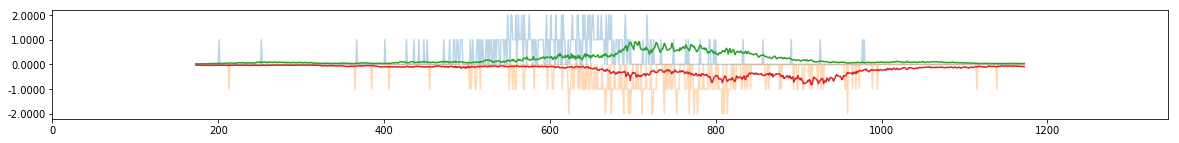

POU5F1 ChIPseq preds


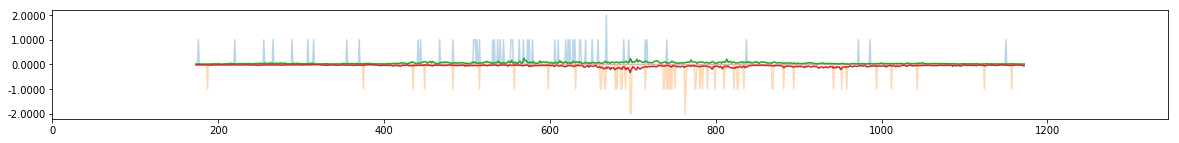

POU5F1 CUTNRUN preds


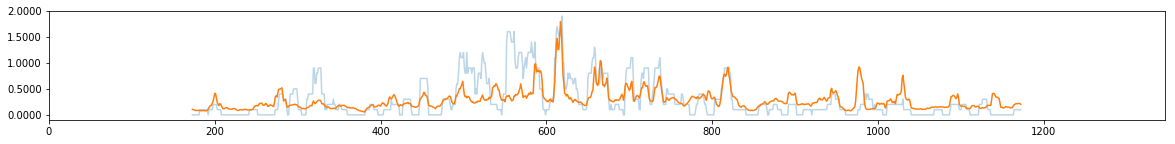

1922
NANOG ChIPseq preds


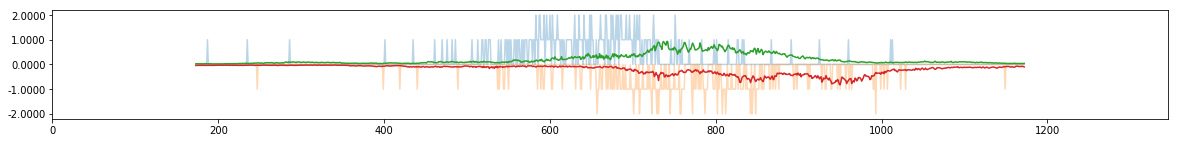

POU5F1 ChIPseq preds


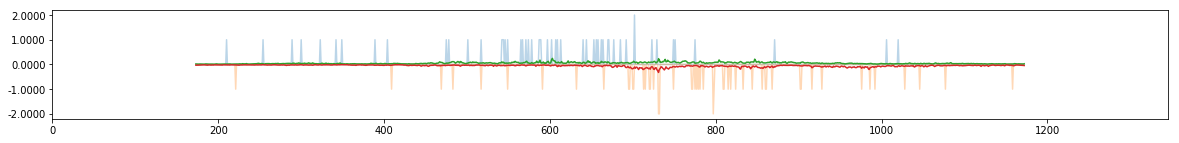

POU5F1 CUTNRUN preds


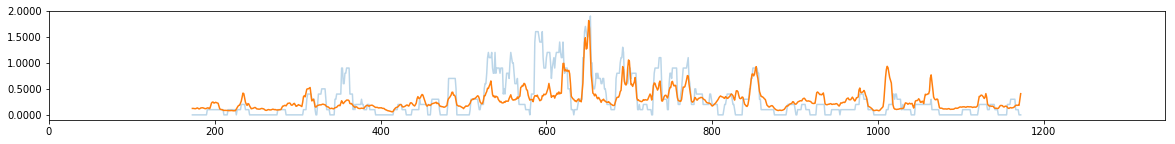

338
NANOG ChIPseq preds


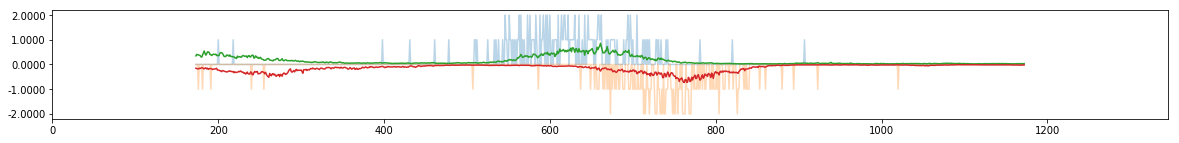

POU5F1 ChIPseq preds


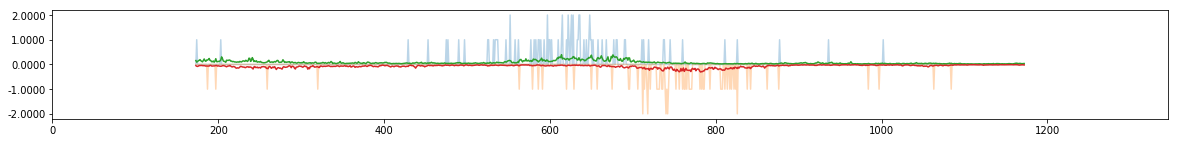

POU5F1 CUTNRUN preds


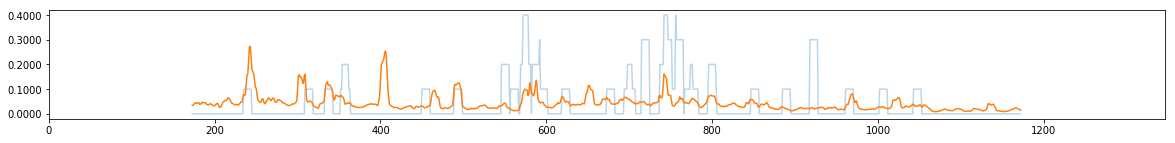

339
NANOG ChIPseq preds


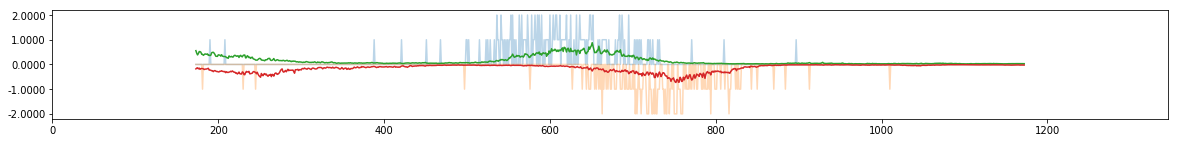

POU5F1 ChIPseq preds


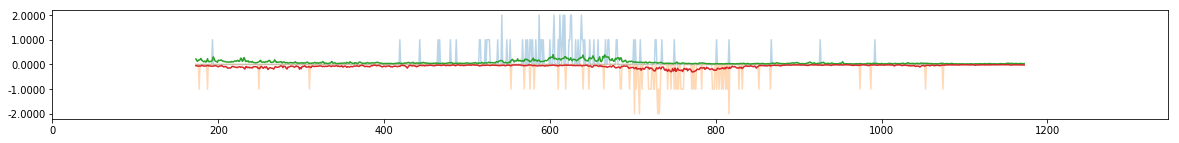

POU5F1 CUTNRUN preds


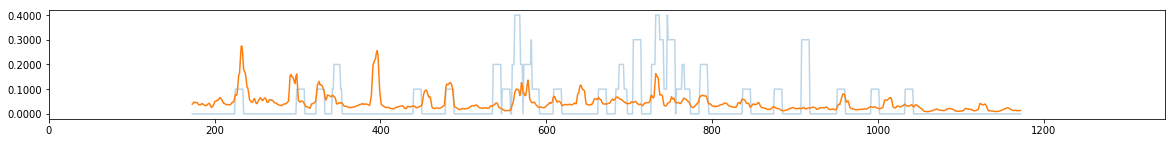

102
NANOG ChIPseq preds


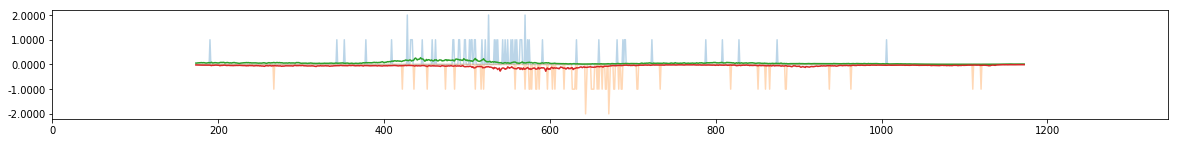

POU5F1 ChIPseq preds


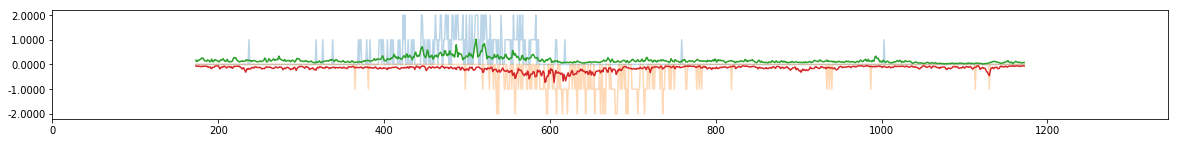

POU5F1 CUTNRUN preds


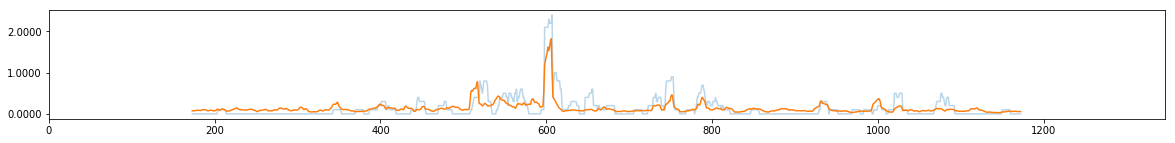

100
NANOG ChIPseq preds


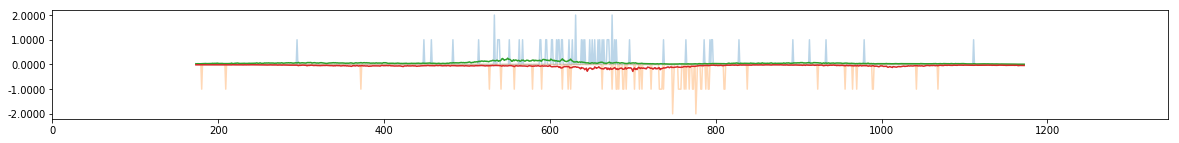

POU5F1 ChIPseq preds


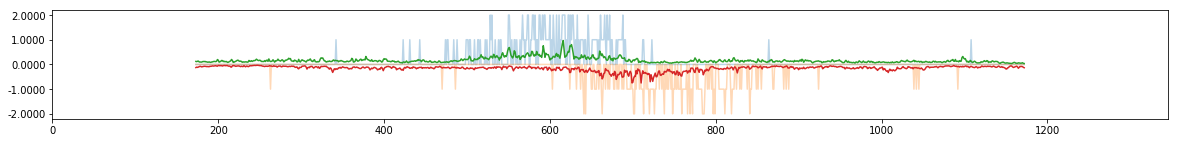

POU5F1 CUTNRUN preds


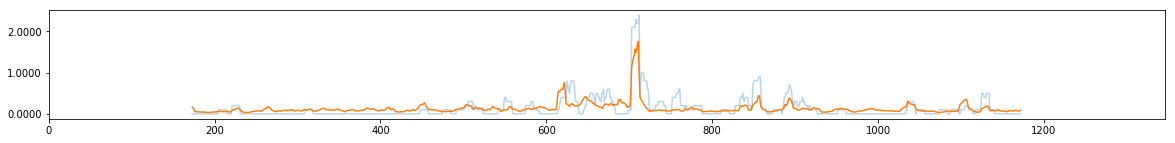

In [0]:
from matplotlib.ticker import FormatStrFormatter

#sort indices by NANOG counts
sorted_nanog_counts = [x[0] for x in 
                       sorted(enumerate(np.sum(test_targets['ChIPseq.NANOG.logcount'],axis=-1)
                                        +np.sum(test_targets['ChIPseq.POU5F1.logcount'],axis=-1)),
                              key=lambda x: -x[1])]
def plot_profile(true_profile, pred_profile_logits):
  pred_profile = (np.sum(true_profile, axis=0)[None,:] #total counts
                  *(np.exp(pred_profile_logits)/
                    np.sum(np.exp(pred_profile_logits),axis=0)[None,:]) )
  plt.figure(figsize=(20,2))     
  total_flanking = seq_len - out_pred_len
  left_flank = int(0.5*total_flanking)
  right_flank = total_flanking - left_flank
  plt.plot(np.arange(out_pred_len)+left_flank, true_profile[:,0], alpha=0.3)
  if (true_profile.shape[1] == 2):
    plt.plot(np.arange(out_pred_len)+left_flank, -true_profile[:,1], alpha=0.3)
  plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
  if (true_profile.shape[1] == 2):
    plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
  plt.xlim(0,seq_len)
  plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
  plt.show()

for idx in sorted_nanog_counts[:10]:
  print(idx)
  print("NANOG ChIPseq preds")
  plot_profile(true_profile=test_targets['ChIPseq.NANOG.profile'][idx],
                         pred_profile_logits=test_preds['ChIPseq.NANOG.profile'][idx])
  print("POU5F1 ChIPseq preds")
  plot_profile(true_profile=test_targets['ChIPseq.POU5F1.profile'][idx],
                         pred_profile_logits=test_preds['ChIPseq.POU5F1.profile'][idx])
  print("POU5F1 CUTNRUN preds")
  plot_profile(true_profile=test_targets['CUTNRUN.POU5F1.profile'][idx],
                         pred_profile_logits=test_preds['CUTNRUN.POU5F1.profile'][idx])